In [9]:
# try:
#     from mylab.imports import *
#     from mylab.DNSS import *
#     from mylab.adam_optimizer import *
#     from mylab.open_3d_visualizer_callback import *
# except:
#     from imports import *
#     from DNSS import *
#     from adam_optimizer import *
#     from open_3d_visualizer_callback import *

# import time

In [10]:
# DNSS.get_DNSS_pointcloud(source, 2, 0.5, show=False)

# Synthetic Data from ModelNet40

In [11]:
############################ CAD VTC SOURCE ############################
# PCD_DENSITY = 20000
# cad_file_path = 'PCDs/VTC/test_00/Assembly_new.stl'
# source = PCUtils.get_pointcloud_from_file(cad_file_path, PCD_DENSITY)

# source_base_transformation = np.array([[0.383232,    -0.923652,    -0.000000,   550.000000],
#                                        [0.000000,     0.000000,    -1.000000,  -200.000000],
#                                        [0.923652,     0.383232,     0.000000,  -100.000000],
#                                        [0.000000,     0.000000,     0.000000,     1.000000]])
# source.transform(source_base_transformation)

In [12]:
# ############################ SOURCE ############################
# working_dir = "PCDs/VTC/3DReconstruction_02/"
# source = reconstructed_workpiece_cropped_removed = PCUtils.get_pointcloud_from_file(f"{working_dir}vtc_3D_reconstruction.ply")
# source

In [13]:
# ############################ TARGET ############################
# TARGET_ID = 2
# working_dir = "PCDs/VTC/3DReconstruction_04/"
# files_names = [zdf_file for zdf_file in sorted(os.listdir(working_dir)) if zdf_file.lower().endswith('.zdf')]

# new_target = PCUtils.get_pointcloud_from_file(working_dir + files_names[TARGET_ID])

# baseTz_poses = [MatrixPose.pose_to_matrix([650.0,  0,  700.0,  -90.0,  0,  -180.0]),
#                 MatrixPose.pose_to_matrix([650.0,  430.0014067382813,  540.673828125,  -180.0,  0.0,  -138.7890006233789]),
#                 MatrixPose.pose_to_matrix([650.0, -430.001, 540.674, 180.0, 0.0, 138.789]),
#                 MatrixPose.pose_to_matrix([950.0, 0.0, 550.0, -90.0, 0.0, 150.0]),
#                 MatrixPose.pose_to_matrix([500.0, 0.0, 920.0, -90.0, 0.0, -180.0]),
#                 MatrixPose.pose_to_matrix([700.0,  0.0,  920.0,  -90.0,  0.0,  -180.0]),
#                 MatrixPose.pose_to_matrix([780.0,  0.0,  920.0,  -90.0,  0.0,  -180.0]),
#                ]

# roi_params = {'corner_x':   200, 'corner_y':    500, 'corner_z':     200,
#               'dimension_x':750, 'dimension_y': 1000, 'dimension_z': 200}

# new_target.transform(baseTz_poses[TARGET_ID])
# new_target = ROI.crop_roi_box(new_target, roi_params)
# new_target = new_target.voxel_down_sample(voxel_size = 1)

# target = NoiseRemoval.remove_statistical_outlier(new_target, nb_neighbors = 500, std_ratio = 2.0)
# #################################################################

In [14]:
# source_ = copy.deepcopy(source)
# target_ = copy.deepcopy(target)

In [15]:
# source_ = get_DNSS_pointcloud(source, 2, 0.85, show=False)
# target_ = get_DNSS_pointcloud(target, 2, 0.85, show=False)

In [16]:
# o3d.visualization.draw_geometries([source_, target_,
#                                    PCUtils.create_coordinate_frame(25, (0, 0, 0))])

# RANSAC ICP

In [17]:
# source, target, source_pts, target_pts = gen_source_targte()

In [18]:
# voxel_size = 2.5
# source_ = copy.deepcopy(source).voxel_down_sample(voxel_size)
# target_ = copy.deepcopy(target).voxel_down_sample(voxel_size)

In [19]:
# start_time = time.time()

# glob_reg_ransac_icp = GlobalRegistrationFPHPICP()
# glob_reg_ransac_icp.set_parameters(voxel_size = 5)

# # cCReg = ZeroCenterRegistration()
# # cCReg.set_parameters(glob_reg_ransac_icp)
# # glob_reg_ransac_icp = cCReg

# new_reg_trans, _ = glob_reg_ransac_icp.register(source_, target_)

# draw_registration_result(source_, target_, new_reg_trans)

# # print(":: Metric: ", RegistrationMetric.get_overlap_ratio(source_, target_, 3, new_reg_trans))
# print("--- %s seconds ---" % (time.time() - start_time))

# Go-ICP

In [20]:
# source, target, source_pts, target_pts = gen_source_targte()

In [21]:
# o3d.visualization.draw_geometries([source, target,
#                                    PCUtils.create_coordinate_frame(25, (0, 0, 0))])

In [22]:
# naive_reg = NaiveRegistration()
# new_reg_trans, _ = naive_reg.register(source_, target_)

# draw_registration_result(source_, target_, new_reg_trans)
# new_reg_trans

In [23]:
# voxel_size = 10
# source_ = copy.deepcopy(source).voxel_down_sample(voxel_size)
# target_ = copy.deepcopy(target).voxel_down_sample(voxel_size)

In [24]:
# source_ = copy.deepcopy(source_).transform(new_reg_trans)

In [25]:
# source_ = copy.deepcopy(source)
# target_ = copy.deepcopy(target)

# start_time = time.time()

# go_icp_reg = GO_ICP()
# go_icp_reg.set_parameters(200, 2)
# cCReg = ZeroCenterRegistration()
# cCReg.set_parameters(go_icp_reg)

# new_reg_trans, _ = cCReg.register(copy.deepcopy(source_), copy.deepcopy(target_))

# draw_registration_result(source_, target_, new_reg_trans)

# print(":: Metric: ", RegistrationMetric.get_overlap_ratio(source_, target_, 3, new_reg_trans))
# print("--- %s seconds ---" % (time.time() - start_time))

In [26]:
# draw_registration_result(source_, target_, np.eye(4))

# Gradient Descent Algorithm for Surface Matching as Point Clouds

In [27]:
import matplotlib.pyplot as plt
from data import ModelNet40
import numpy as np
import torch
import copy
import numpy as np
import open3d as o3d
from scipy.spatial.transform import Rotation as R
from vtctestregistrationdata import VTCTestRegistrationData
from generatedtrainingdata import GeneratedTrainingData

In [28]:
def draw_registration_result(source, target, transformation):
    SIZE_PERCENTAGE = 0.15
    v_size = round(max(source.get_max_bound() - source.get_min_bound()) * SIZE_PERCENTAGE, 4)

    source = copy.deepcopy(source)
    target = copy.deepcopy(target)
    coord_syst = o3d.geometry.TriangleMesh.create_coordinate_frame(size=v_size, origin=[0, 0, 0])
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0 ])  # 1, 0.706, 0
    target_temp.paint_uniform_color([0, 0.651, 0.929]) #  # 0, 0.651, 0.929
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp, coord_syst])

def initialize_pointcloud(pts):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    return pcd

def plot_accuracy_and_loss(loss_train, loss_val):
    """Plot two numpy arrays on two different axis"""
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(loss_train, color='red')
    plt.plot(loss_val, color='blue')
    plt.legend(['Training loss', 'Validation loss']) 
    plt.show()

#########
# generated_training_data_path = 'generated_training_dataset.hdf5'
# trainset = GeneratedTrainingData(None, generated_training_data_path)

# idx = 2
# test_cts = trainset[idx]
# scaling = 1
# target = initialize_pointcloud(test_cts[0].T.detach().cpu().numpy()*scaling)
# source = initialize_pointcloud(test_cts[1].T.detach().cpu().numpy()*scaling)
# transform = np.eye(4)
# transform[:3, :3] = test_cts[2].detach().cpu().numpy()
# transform[:3, 3] = test_cts[3].detach().cpu().numpy() * scaling

# draw_registration_result(target,source,transform)

In [29]:
import torch
import torch.nn as nn
from pytorch3d.transforms import (matrix_to_quaternion, quaternion_to_matrix, euler_angles_to_matrix, Transform3d)
from pytorch3d.loss import chamfer_distance
import torch.optim as optim
from pytorch3d.ops import (ball_query, knn_points, sample_farthest_points)

# class F1ScoreLoss(nn.Module):
#     def __init__(self, threshold, K=10):
#         super(F1ScoreLoss, self).__init__()
#         self.threshold = threshold
#         self.K = K

#     def forward(self, x, y):
#         def get_overlap(x, y):
#             b_query = ball_query(y, x, K=self.K, radius = self.threshold)

#             # Count the number of points (rows) in each batch where there is at least one non -1 value
#             # Create a tensor
#             x = (b_query[0]).sum(dim=2) * 1e10

#             # Use torch.clamp to create a tensor with values between 0 and 1
#             # Values greater than the threshold become 1, and others become 0, x - threshold
#             binary_tensor = torch.clamp(x, min=0, max=1.0)

#             # Count the number of values greater than the threshold using torch.sum()
#             non_negative_points_per_batch = torch.sum(binary_tensor, dim=1)

#             total_points_per_batch = torch.tensor([len(batch) for batch in y])

#             overlap_source_on_target = non_negative_points_per_batch / total_points_per_batch
#             return overlap_source_on_target

#         precision = get_overlap(x, y)
#         recall = get_overlap(y, x)

#         # Return the negative F1 score as a loss (minimizing F1 score is equivalent to maximizing overlap)
#         f1_score = 2*(precision * recall)/(precision + recall)
#         return - torch.nan_to_num(f1_score, nan=2).mean()


# x = torch.tensor([[[0,0,0],  [0,0,1],  [0,0,2]],    [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # source
# y = torch.tensor([[[0.1,0,0],[0.1,0,1],[0,0,2.05]], [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # template


# # Usage:
# loss_function = F1ScoreLoss(0.05)
# loss_function(x, y), loss_function(y, x)

In [360]:
class F1ScoreLoss(nn.Module):
    def __init__(self, threshold, K=10):
        super(F1ScoreLoss, self).__init__()
        self.threshold = threshold
        self.K = K

    def forward(self, x, y, reduction = 'sum'):
        def get_overlap(x, y):
            b_query = ball_query(y, x, K=self.K, radius = self.threshold)

            # Count the number of points (rows) in each batch where there is at least one non -1 value
            x = (b_query[0]).sum(dim=2)
            non_negative_points_per_batch = torch.sum(x, dim=1)

            return non_negative_points_per_batch

        precision = get_overlap(x, y)
        recall = get_overlap(y, x)

        # Return the F1 score as a loss (minimizing F1 score is equivalent to maximizing overlap)
        f1_score = 2*(precision * recall)/(precision + recall)
        if reduction == 'sum':
            return torch.nan_to_num(f1_score, nan=0).sum()
        else:
            return torch.nan_to_num(f1_score, nan=0)
    
# x = torch.tensor([[[0,0,0],  [0,0,1],  [0,0,2]],    [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # source
# y = torch.tensor([[[0.1,0,0],[0.1,0,1],[0,0,2.05]], [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # template


# Usage:
# loss_function = F1ScoreLoss(0.05)
# loss_function(x, y), loss_function(y, x)

In [63]:
class NoiseRemoval():
    @staticmethod
    def __display_inlier_outlier(cloud, ind):
        inlier_cloud = cloud.select_by_index(ind)
        outlier_cloud = cloud.select_by_index(ind, invert=True)

        print("Showing outliers (red) and inliers (gray): ")
        outlier_cloud.paint_uniform_color([1, 0, 0])
        inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
        o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

    @staticmethod
    def check_pointcloud(obj):
        if torch.is_tensor(obj):
            print("it is tensor")
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(obj.detach().cpu().numpy())
            from_type = "torch"
            
        return pcd, from_type


    @staticmethod
    def remove_statistical_outlier(pcd, nb_neighbors = 600, std_ratio = 2.0, show = False):
        """ 
            Inputs:
                nb_neighbors (int) – Number of neighbors around the target point.
                std_ratio (float) – Standard deviation ratio.
        """
        
        pcd, from_type = NoiseRemoval.check_pointcloud(pcd)

        _, ind = pcd.remove_statistical_outlier(nb_neighbors, std_ratio, print_progress=False)
        if show:
            NoiseRemoval.__display_inlier_outlier(pcd, ind)

        pcd = pcd.select_by_index(ind)

        if from_type == "torch":
            pcd = torch.from_numpy(np.asarray(pcd.points))

        return pcd

# print("Radius oulier removal")
#     cl, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
#     display_inlier_outlier(voxel_down_pcd, ind)

In [424]:
sample_farthest_points(torch.rand(1,2048,3), lengths=torch.tensor([2048]), K=1024)[1]

torch.Size([1, 1024])

In [ ]:
x = sample_farthest_points(x, lengths=torch.tensor([2048]), K=1024)[0]
# def sample_farthest_points(
#     points: torch.Tensor,
#     lengths: Optional[torch.Tensor] = None,
#     K: Union[int, List, torch.Tensor] = 50,
#     random_start_point: bool = False,
# ) -> Tuple[torch.Tensor, torch.Tensor]:
# using sample_farthest_points worsen the aligment due to the homogeneous sampling of points acrros all the point cloud which increases the probability of adding outliers in non dense areas

x = sample_farthest_points(x.view(1,N_before_sampling,3), torch.Tensor([N_before_sampling]), N)[0].view(N,3)
y = sample_farthest_points(y.view(1,N_before_sampling,3), torch.Tensor([N_before_sampling]), N)[0].view(N,3)

In [92]:
def projected_chamfer_loss(x, y):
    def get_projected_point_cloud(x, y, dim=0):
        x_cln = x.clone()
        y_cln = y.clone()

        x_cln[:,:,dim] = 0
        y_cln[:,:,dim] = 0

        return x_cln, y_cln

    x_yz, y_yz = get_projected_point_cloud(x, y, dim=0)
    x_xz, y_xz = get_projected_point_cloud(x, y, dim=1)
    x_xy, y_xy = get_projected_point_cloud(x, y, dim=2)
    
    cd_yx, _ = chamfer_distance(x_yz,y_yz)
    cd_xx, _ = chamfer_distance(x_xz,y_xz)
    cd_xy, _ = chamfer_distance(x_xy,y_xy)

    return cd_yx + cd_xx + cd_xy

import torch.nn.functional as F

class RigidMotionLoss(nn.Module):
    def __init__(self):
        super(RigidMotionLoss, self).__init__()
        self.discount_factor = 1

    def forward(self, rotation_ab, translation_ab, rotation_ba, translation_ba, iteration_n = 1):
        batch_size = rotation_ab.size(0)
        identity = torch.eye(3, device=rotation_ab.device).unsqueeze(0).repeat(batch_size, 1, 1)
        return (F.mse_loss(torch.matmul(rotation_ba.transpose(2, 1), rotation_ab), identity) \
                   + F.mse_loss(translation_ba, translation_ab)) * self.discount_factor**iteration_n

In [346]:
import numpy as np
from pytorch3d.transforms import (matrix_to_quaternion, quaternion_to_matrix, euler_angles_to_matrix, 
                                  quaternion_apply, Transform3d)
def get_initial_quaternions():
    # Define the range (-A to A) for the rotations
    A = 20  # Replace with your desired range in degrees

    # Number of divisions or steps within the range
    num_steps = 4  # Adjust this to your desired number of steps

    # Generate the grid of Euler rotations
    x_angles = np.linspace(-A, A, num_steps)
    y_angles = np.linspace(-A, A, num_steps)

    # Create a grid of Euler rotations using meshgrid
    x_rotations, y_rotations = np.meshgrid(np.radians(x_angles), np.radians(y_angles))

    # Stack the X and Y rotations into a single array
    x_rotations_rav = x_rotations.ravel()
    n_initial_quat = x_rotations_rav.shape[0]

    rotations = np.column_stack((np.zeros(n_initial_quat), y_rotations.ravel(), x_rotations_rav))

    if num_steps % 2 == 0:
        rotations = np.vstack([np.array([0,0,0]), rotations])
        n_initial_quat += 1

    rotations = torch.from_numpy(rotations).float()

    # Now, 'rotations' contains the grid of Euler rotations in a single 2D array

    initial_quaternions = matrix_to_quaternion(euler_angles_to_matrix(rotations, "XYZ"))

    return n_initial_quat, initial_quaternions



In [412]:
########
N_before_sampling = 2048
N = 2048

if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# generated_training_data_path = 'generated_training_dataset.hdf5'
# trainset = GeneratedTrainingData(None, generated_training_data_path, N)
trainset = VTCTestRegistrationData('vtc_testing_dataset.hdf5', N_before_sampling)

idx = 36
test_cts = trainset[idx]
scaling = 1
nb_neighbors = 30
std_ratio = 1.65
double_reg_scr_to_tgt = False   # Flag to enable the double registration between scr to tgt and tgt to scr

x = test_cts[1].T.view(N_before_sampling,3)
y = test_cts[0].T.view(N_before_sampling,3)

# Removal of noise from target point cloud
y = NoiseRemoval.remove_statistical_outlier(y, nb_neighbors = nb_neighbors, std_ratio = std_ratio)


x = x - torch.mean(x, dim=0)
y = y - torch.mean(y, dim=0)

x = x.float()
y = y.float()

transform = np.eye(4)
transform[:3, :3] = test_cts[2].detach().cpu().numpy()
transform[:3, 3] = test_cts[3].detach().cpu().numpy() * scaling

# draw_registration_result(initialize_pointcloud(x.detach().cpu().numpy()*scaling),
#                          initialize_pointcloud(y.detach().cpu().numpy()*scaling),
#                          transform)

# Align target to source
x = x.view(1,-1,3).to(device) # source
y = y.view(1,-1,3).to(device) # target

# Double registration from tgt to scr and viceverse
if double_reg_scr_to_tgt:
    # x and y must have the same dimentions
    x_copy = x.clone()
    x = torch.cat((x, y), dim=0)
    y = torch.cat((y, x_copy), dim=0)


x.shape, y.shape

it is tensor


(torch.Size([1, 2048, 3]), torch.Size([1, 1942, 3]))

Initial values of rotation: 
 tensor([[ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.9698,  0.0302, -0.1710, -0.1710],
        [ 0.9831,  0.0101, -0.1734, -0.0573],
        [ 0.9831, -0.0101, -0.1734,  0.0573],
        [ 0.9698, -0.0302, -0.1710,  0.1710],
        [ 0.9831,  0.0101, -0.0573, -0.1734],
        [ 0.9966,  0.0034, -0.0580, -0.0580],
        [ 0.9966, -0.0034, -0.0580,  0.0580],
        [ 0.9831, -0.0101, -0.0573,  0.1734],
        [ 0.9831, -0.0101,  0.0573, -0.1734],
        [ 0.9966, -0.0034,  0.0580, -0.0580],
        [ 0.9966,  0.0034,  0.0580,  0.0580],
        [ 0.9831,  0.0101,  0.0573,  0.1734],
        [ 0.9698, -0.0302,  0.1710, -0.1710],
        [ 0.9831, -0.0101,  0.1734, -0.0573],
        [ 0.9831,  0.0101,  0.1734,  0.0573],
        [ 0.9698,  0.0302,  0.1710,  0.1710]], requires_grad=True)


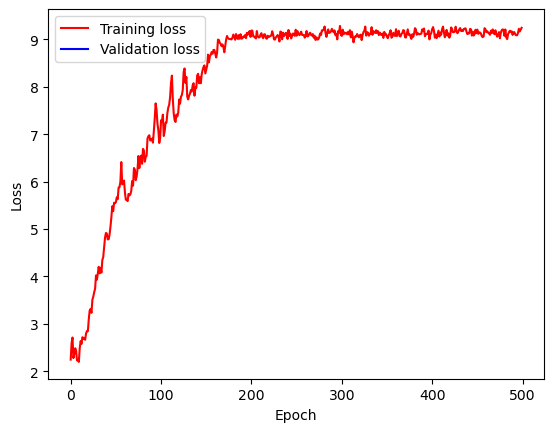

In [413]:
def chamfer_loss(x, y):
    loss_chamfer, _ = chamfer_distance(x,y)
    return loss_chamfer

def projected_chamfer_loss(x, y):
    loss_chamfer, _ = chamfer_distance(x,y)
    return loss_chamfer

def get_B_eye_rotation_matrices(B):
    # Create a batch of identity matrices
    return torch.eye(3).unsqueeze(0).expand(B, -1, -1)

def get_B_eye_quaternions(B):
    # Create a batch of identity matrices
    return torch.tensor([1,0,0,0]).float().unsqueeze(0).expand(B, -1)

def check_convergence(w0, w1, threshold = 0.00005):
    return np.linalg.norm(w0-w1) < threshold

def get_gradient_norm(t_params, quat_params):
    return torch.cat((t_params.grad, quat_params.grad), 1).norm(dim=-1)

multiple_initial_value = True
n_initial_quat, initial_quaternions = get_initial_quaternions()

if multiple_initial_value:
    x = x.expand(n_initial_quat, -1, 3)
    y = y.expand(n_initial_quat, -1, 3)
else:
    B = 1
    initial_quaternions = matrix_to_quaternion(get_B_eye_rotation_matrices(B)).requires_grad_()
    n_initial_quat = initial_quaternions.shape[0]


lr = 0.055         # Learning rate
B = x.shape[0]    # Batch size
K = 5             # Number of neighbors
radius = 0.15     # Neighbors search radius
gamma = 2         # Overlap loss constant
alpha = 6         # Project loss constant
epochs = 500        # No of epochs to run
rg_mot_loss_coeff = 0 # Coefficient for the double registration rigid motion loss

rigid_motion_loss = RigidMotionLoss()
f1_loss_function = F1ScoreLoss(radius*radius, K=K)
t_params = torch.zeros(B, 3, requires_grad=True)

# Initialize quaternions:
quat_params = initial_quaternions.requires_grad_()
print("Initial values of rotation: \n", quat_params)
# initial_quaternions.requires_grad_()

optimizer = optim.Adam([t_params, quat_params], lr=lr)

loss_tracking = []
grad_tracking = []


for iter in range(epochs):
    
    t = Transform3d().rotate(quaternion_to_matrix(quat_params)).translate(t_params).to(device) # scale(s1_params).
    
    y_transformed = t.transform_points(y).float()

    # Forward pass and backward pass
    ####### RIGID MOTION LOSS #######
    # quat2mtx = quaternion_to_matrix(quat_params)
    # rig_mot_loss = rg_mot_loss_coeff * rigid_motion_loss(quat2mtx[0].view(1,3,3), t_params[0].view(1,1,3),
    #               quat2mtx[1].view(1,3,3), t_params[1].view(1,1,3))
    # rig_mot_loss = 0
    ################################

    
    
    loss = chamfer_loss(x, y_transformed) + alpha * projected_chamfer_loss(x, y_transformed) \
        + gamma * f1_loss_function(x, y_transformed) 
        
    # + gamma * f1_loss_function(x, y_transformed)
    # chamfer_loss(x, y_transformed)
    # f1_loss_function(x, y_transformed)
    # dist(x.cuda(), y_transformed.cuda()).sum()
    # + rig_mot_loss

    loss.backward()
    
    loss_tracking.append(loss.cpu().detach().numpy())

    # grad_tracking.append(get_gradient_norm(t_params, quat_params).cpu().detach().numpy())

    # Update parameters using the optimizer
    
    # print("Params (before): ", t_params, quat_params)
    optimizer.step()
    # print("Params (after): ", t_params, quat_params)

    # Zero out gradients for the next iteration
    optimizer.zero_grad()

plot_accuracy_and_loss(loss_tracking, grad_tracking)

# X and Y are both zero-centered at this point
def draw_registration_result_from_tensor(idx):
    # draw_registration_result(initialize_pointcloud(x[idx].detach().cpu().numpy()),
    #                         initialize_pointcloud(y[idx].detach().cpu().numpy()),
    #                         np.eye(4))

    draw_registration_result(initialize_pointcloud(x[idx].detach().cpu().numpy()),
                            initialize_pointcloud(y_transformed[idx].detach().cpu().numpy()),
                            np.eye(4))



In [419]:
################
# As expected, F1 overlap loss provides a good indication of successful registration
# if iter == int(epochs * 0.4):
f1_scores = f1_loss_function(x, y_transformed, reduction = None)
# n_tops = 1
# idx_top_f1 = torch.topk(f1_scores, n_tops)[0].long()
idx_top_f1 = torch.argmax(f1_scores)
f1_scores, idx_top_f1
# x = x[idx_top_f1]
# y = y[idx_top_f1]
# y_transformed = y_transformed[idx_top_f1]

# t_params = t_params[idx_top_f1]
# quat_params = quat_params[idx_top_f1]
################
draw_registration_result_from_tensor(idx=idx_top_f1)

In [420]:
x.shape, n_initial_quat

(torch.Size([17, 2048, 3]), 17)

In [404]:
for idx in range(n_initial_quat):
    # print(matrix_to_quaternion(euler_angles_to_matrix(rotations, "XYZ"))[idx])
    draw_registration_result_from_tensor(idx=idx)

In [90]:

# draw_registration_result_from_tensor(idx=1)

In [24]:
o3d.visualization.draw_geometries([source, target, PCUtils.create_coordinate_frame(100, (0, 0, 0))],
                                  window_name = 'DNSS Source Point Cloud')

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Controlador no válido. 


In [ ]:
source.estimate_normals(
    search_param = o3d.geometry.KDTreeSearchParamHybrid(2, max_nn=30),
    fast_normal_computation=False
)

target.estimate_normals(
    search_param = o3d.geometry.KDTreeSearchParamHybrid(2, max_nn=30),
    fast_normal_computation=False
)

In [10]:
o3d.io.write_point_cloud(f"tv_source.ply", source, write_ascii=True)
o3d.io.write_point_cloud(f"tv_target.ply", target, write_ascii=True)

True

In [39]:
tr = quaternion_multiply(R.from_matrix(gt_matrix[:3,:3]).as_quat(), np.array([0,0,0,1]))
eye = np.eye(4)
eye[:3,:3] = R.from_quat(tr).as_matrix()

In [3]:
max_angle_range = 30
max_translation = 3

def gen_source_targte():
    PCD_DENSITY = 10000
    source, target = GenerateSyntheticClouds.generate_source_target(
        r'C:\Users\AlejandroHVilla\Downloads\Datasets\ModelNet10\ModelNet10\sofa\train\sofa_0660.off',
#         r'C:\Users\AlejandroHVilla\Downloads\Datasets\ModelNet10\ModelNet10\monitor\train\monitor_0450.off',
                                                                        PCD_DENSITY)
    
    print(":: Point cloud dimensions: ", np.max(np.asarray(source.points), axis=0))
    
    max_angle_range = 30
    max_translation = 3
    
    gt_matrix = MatrixPose.pose_to_matrix([random.randint(-max_translation,max_translation),
                                              random.randint(-max_translation,max_translation),
                                              random.randint(-max_translation,max_translation),
                                              random.randint(-180,180),
                                              random.randint(-max_angle_range,max_angle_range),
                                              random.randint(-max_angle_range,max_angle_range)])

    gt_euler = R.from_matrix(gt_matrix[:3,:3]).as_euler('ZYX', degrees=True)
    print(":: Ground truth:\n", gt_matrix, '\n::Ground truth (Euler):\n', gt_euler)
    target.transform(gt_matrix)

    source_pts = np.asarray(source.points)
    target_pts = np.asarray(target.points)
    
    
    
    draw_registration_result(source, target, np.eye(4))
    
    return source, target, source_pts, target_pts, gt_euler

source, target, source_pts, target_pts, gt_euler = gen_source_targte()

:: Point cloud dimensions:  [18.17740059 44.29135132 17.23791576]
:: Ground truth:
 [[-0.99604297  0.05751173 -0.06775543  0.        ]
 [-0.01738599 -0.87374907 -0.48606615  0.        ]
 [-0.08715574 -0.48296477  0.87129152 -2.        ]
 [ 0.          0.          0.          1.        ]] 
::Ground truth (Euler):
 [-179.    5.  -29.]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Controlador no válido. 


In [6]:
import numpy as np
import itertools
from scipy.spatial import cKDTree
from scipy.spatial.transform import Rotation as R


def overlap_loss(X, Y, R_quad, T_transl, threshold):
    T = R.from_quat(R_quad).as_matrix()
    X_transformed = (T[0:3, 0:3] @ X.T ).T + T_transl
    tree = cKDTree(X_transformed)
    searched_nn_points = tree.query_ball_point(Y, threshold, workers=-1)
    searched_nn_points = list(itertools.chain(*searched_nn_points))
    return len(searched_nn_points) / X_transformed.shape[0]

def check_convergence(w0, w1, threshold = 0.00005):
    return np.linalg.norm(w0-w1) < threshold

grad_history = []
loss_history = []

def gradient_descent(X, Y, R_quad, T_transl, lr=0.01, max_iter=1000, tol=1e-3, threshold=100, callbacks=[]):
    T = R_quad
    Trl = T_transl
    delta = 0.1

    adam = AdamOptim(eta=lr, beta1=0.9, beta2=0.999, epsilon=1e-8)
    step = 1
    
    loss_history.append(-overlap_loss(X, Y, T, Trl, threshold))
    
    for i in range(max_iter):
        
        grad = np.zeros(7)
        grad[0] = -(overlap_loss(X, Y, T + np.array([delta, 0, 0, 0]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([delta, 0, 0, 0]), np.array([0,0,0]), threshold))/(2*delta)
        grad[1] = -(overlap_loss(X, Y, T + np.array([0, delta, 0, 0]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([0, delta, 0, 0]), np.array([0,0,0]), threshold))/(2*delta)
        grad[2] = -(overlap_loss(X, Y, T + np.array([0, 0, delta, 0]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([0, 0, delta, 0]), np.array([0,0,0]), threshold))/(2*delta)
        grad[3] = -(overlap_loss(X, Y, T + np.array([0, 0, 0, delta]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([0, 0, 0, delta]), np.array([0,0,0]), threshold))/(2*delta)
        
        grad[4] = -(overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl + np.array([delta,0,0]), threshold) - overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl - np.array([delta,0,0]), threshold))/(2*delta)
        grad[5] = -(overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl + np.array([0,delta,0]), threshold) - overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl - np.array([0,delta,0]), threshold))/(2*delta)
        grad[6] = -(overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl + np.array([0,0,delta]), threshold) - overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl - np.array([0,0,delta]), threshold))/(2*delta)
        
        grad_history.append(np.linalg.norm(grad))

        T_old = np.append(T, Trl).copy()
        T_all, _ = adam.update(step, w=np.append(T, Trl), b=0, dw=grad, db=0)
        T = T_all[:4]
        Trl = T_all[4:]
        
        step += 1
        loss_history.append(-overlap_loss(X, Y, T, Trl, threshold))
        # T = T + lr * grad
        
        # Check convergence
        # obj_new = overlap_loss(X, Y, T_new, threshold)
        
        if check_convergence(T_old, np.append(T, Trl), tol): #np.linalg.norm(grad) < tol:
            print(f":: Tolerance reached at iter {i}!")
            break

        for c in callbacks:
            c(T, np.array([0,0,0]))
        
    return T, Trl

best_rot, best_transl = gradient_descent(source_pts, target_pts, np.array([0., 0., 0., 1.]), np.array([0,0,0]),
                            lr=0.1, max_iter=500, tol=0.005, threshold=1, callbacks=[])
best_rot, best_transl

(array([0.11004634, 0.39401171, 0.09324152, 0.47509236]),
 array([-0.85399259,  0.72191244, -0.91459524]))

In [7]:
# Predicted transformation vs GT
R.from_quat(best_rot).as_euler('ZYX', degrees=True), "gt_euler: ", gt_euler

(array([67.14786717, 61.73601322, 69.36331002]),
 'gt_euler: ',
 array([-179.,    5.,  -29.]))

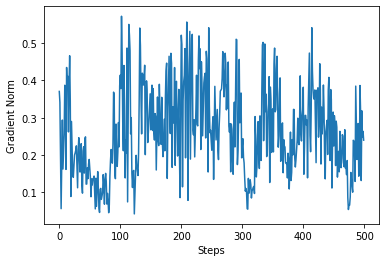

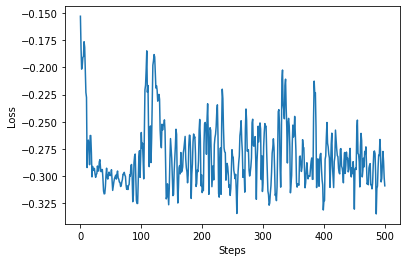

In [8]:
plt.plot(range(len(grad_history)), grad_history)
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.show()

plt.plot(range(len(loss_history)), loss_history)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [ ]:
eye = np.eye(4)
eye[:3,:3] = R.from_quat(best_rot).as_matrix() 
eye[:3,3] = best_transl
# eye[:3,:3] = R.align_vectors(target_pts, source_pts)[0].as_matrix()
draw_registration_result(source, target, eye)


reg_checker_within_angular_limits(best_rot, [180, max_angle_range, max_angle_range]),
reg_checker_within_roi(source, roi_params)

In [ ]:
# Registration checkers
roi_params = {'corner_x':  -100, 'corner_y':    100, 'corner_z':     100,
              'dimension_x':200, 'dimension_y': 200, 'dimension_z': 200}

# Within ROI
def reg_checker_within_roi(transf_source, roi_params, n_points_exception=1):
    """
        args:
            transf_source: o3d.pointcloud
            roi_params: Dictionary defining the ROI
        output:
            checker: bool, True if a point cloud, e.g. transformed source, falls within roi, else False
    
    """
    cropped_pcd = ROI.crop_roi_box(transf_source, roi_params, inverse = True)
    checker = np.asarray(cropped_pcd.points).shape[0] < n_points_exception
    return checker

# Within expected angular range
def reg_checker_within_angular_limits(reg_trans, max_euler_angles):
    """
        args:
            reg_trans: np.ndarray, 4x4 homogeneous, 3x3 rotation matrix, (4,) quaterion or (3,) euler
            max_euler_angles: Maximum rotation given in Euler ZYX
        output:
            checker: bool, True if transformation angles fall within allowable limits, else False
    """
    reg_trans = np.asarray(reg_trans)
    max_euler_angles = np.abs(np.asarray(max_euler_angles))[:3]
    
    if reg_trans.shape == (4,):
        # Quaternion
        reg_trans_euler = R.from_quat(reg_trans).as_euler('ZYX', degrees=True)
    
    elif reg_trans.shape == (3,):
        # Euler angle ZYX
        reg_trans_euler = reg_trans
    
    elif reg_trans.shape[0] <= 4 and reg_trans.shape[1] <= 4:
        # Rotation matrix
        reg_trans_euler = R.from_matrix(reg_trans[:3,:3]).as_euler('ZYX', degrees=True)
    
    print(f":: Reg Checker Angle Limits: {reg_trans_euler} within +- {max_euler_angles}")
    checker = not np.any(np.logical_and(reg_trans_euler > max_euler_angles, reg_trans_euler < -max_euler_angles))
    return checker
    


In [2]:
# Penalty to deviate from orthogonality:
    
def loss_orthogonality(alpha, R):
    if R.shape == (4,4):
        R = R[:3, :3]
    return alpha * np.linalg.norm(R.T @ R - np.eye(4))

In [45]:
def get_mesh_from_pcd(pcd):
    
    pcd.estimate_normals(
        search_param = o3d.geometry.KDTreeSearchParamHybrid(20, max_nn=30),
        fast_normal_computation=False
    )
    
    return o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,
                                                                           o3d.utility.DoubleVector([0.5,5,10,15,20]))


mesh = get_mesh_from_pcd(source)

mesh.get_surface_area()

In [47]:
draw_registration_result(mesh, target, eye)

In [ ]:
########

import numpy as np

def gradient_descent(points1, points2, num_iterations, learning_rate):
    """
    Maximizes overlap between two surfaces as point clouds using gradient descent.

    Args:
        points1 (numpy array): Point cloud of surface 1
        points2 (numpy array): Point cloud of surface 2
        num_iterations (int): Number of iterations to run gradient descent
        learning_rate (float): Learning rate to use for gradient descent

    Returns:
        numpy array: Translation vector that maximizes overlap between the two surfaces
    """
    # Initialize translation vector to zero
    translation = np.zeros((3,))

    # Loop over the specified number of iterations
    for i in range(num_iterations):
        # Compute the gradient of the overlap function with respect to the translation vector
        gradient = compute_gradient(points1, points2, translation)

        # Update the translation vector using gradient descent
        translation -= learning_rate * gradient

    # Return the final translation vector
    return translation


def compute_gradient(points1, points2, translation):
    """
    Computes the gradient of the overlap function with respect to the translation vector.

    Args:
        points1 (numpy array): Point cloud of surface 1
        points2 (numpy array): Point cloud of surface 2
        translation (numpy array): Translation vector

    Returns:
        numpy array: Gradient of the overlap function with respect to the translation vector
    """
    # Compute the transformed point cloud for surface 1
    transformed_points1 = points1 + translation

    # Compute the overlap between the two point clouds
    overlap = compute_overlap(transformed_points1, points2)

    # Compute the gradient of the overlap function with respect to the translation vector
    gradient = np.zeros((3,))
    for i in range(3):
        delta = np.zeros((3,))
        delta[i] = 1
        translation_plus_delta = translation + delta
        transformed_points1_plus_delta = points1 + translation_plus_delta
        overlap_plus_delta = compute_overlap(transformed_points1_plus_delta, points2)
        gradient[i] = (overlap_plus_delta - overlap) / learning_rate

    # Return the gradient
    return gradient


def compute_overlap(points1, points2):
    """
    Computes the overlap between two point clouds.

    Args:
        points1 (numpy array): Point cloud of surface 1
        points2 (numpy array): Point cloud of surface 2

    Returns:
        float: Overlap between the two point clouds
    """
    # Compute the distance between each point in point cloud 1 and the nearest point in point cloud 2
    distances = np.zeros((points1.shape[0],))
    for i in range(points1.shape[0]):
        distances[i] = np.min(np.linalg.norm(points1[i] - points2, axis=1))

    # Compute the overlap as the sum of the distances
    overlap = np.sum(distances)

    # Return the overlap
    return overlap

In [ ]:
def quaternion_multiply(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)


def daction3(pt, mat):
    '''derivative of SE(3) transformation of a 3D point'''
    R = mat[0:3, 0:3]
    skew_sym_p = np.array([
        [0.0, -pt[2], pt[1]],
        [pt[2], 0.0, -pt[0]],
        [-pt[1], pt[0], 0.0]
    ])
    rmat = np.dot(-R, skew_sym_p)
    return np.array([
        [R[0, 0], R[0, 1], R[0, 2], rmat[0, 0], rmat[0, 1], rmat[0, 2]],
        [R[1, 0], R[1, 1], R[1, 2], rmat[1, 0], rmat[1, 1], rmat[1, 2]],
        [R[2, 0], R[2, 1], R[2, 2], rmat[2, 0], rmat[2, 1], rmat[2, 2]]
    ])

daction3(np.array([1,2,3]), np.eye(4))

# array([0., 0., 0., 1.]) quaternion of the identity matrix
# r.as_euler('ZYX', degrees=True)

In [ ]:
source, target, source_pts, target_pts = gen_source_targte()

voxel_size = 1
source_ = copy.deepcopy(source).voxel_down_sample(voxel_size)
target_ = copy.deepcopy(target).voxel_down_sample(voxel_size)

start_time = time.time()

gen_icp = ICP_Generalized()
gen_icp.set_parameters(max_correspondence_distance=50)
# cCReg = ZeroCenterRegistration()
# cCReg.set_parameters(gen_icp)

new_reg_trans, _ = gen_icp.register(copy.deepcopy(source_),
                                  copy.deepcopy(target_) )

draw_registration_result(source_, target_, new_reg_trans)

# print(":: Metric: ", RegistrationMetric.get_overlap_ratio(source_, target_, 3, new_reg_trans))
print("--- %s seconds ---" % (time.time() - start_time))